<a href="https://colab.research.google.com/github/ariabishma/JIPITI/blob/main/GPT_Shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-05-26 14:05:24--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

input.txt.2         100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2023-05-26 14:05:24 (64.4 MB/s) - ‘input.txt.2’ saved [1115394/1115394]



In [2]:
import tensorflow as tf
import numpy as np 
from tensorflow.keras.layers import TextVectorization, Dense, Input, Embedding, Layer, Dropout, LayerNormalization
import matplotlib.pyplot as plt

In [476]:
context_size = 32
batch_size = 16 # how many independent sequences will we process in parallel?
n_embd = 64

In [477]:
with open('./input.txt', 'r', encoding='utf-8') as f:
    text = f.readlines()

In [478]:
vectorizer = TextVectorization(split="character",ragged=True)
# vectorizer = TextVectorization(max_tokens=1000,ragged=True)
vectorizer.adapt(text)

vocabs = vectorizer.get_vocabulary()

vocab_size = vectorizer.vocabulary_size()
data = vectorizer(text).flat_values
data_size = data.shape[0]

In [479]:
vocab_size

31

In [480]:
decode = lambda encoded : ''.join([vocabs[i] for i in encoded])

In [481]:
n = int(0.9*len(data)) # train validation split
train_data = data[:n]
val_data = data[n:]

In [482]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = np.random.randint(len(data) - context_size, size = (batch_size,)) # generate random text position 
    x = np.stack([data[i:i+context_size] for i in ix])
    y = np.stack([data[i+1:i+context_size+1] for i in ix])
    return x, y

In [483]:
xb, yb = get_batch('train')

In [484]:
class SelfAttention(tf.keras.layers.Layer):
  def __init__(self, head_size):
    super(SelfAttention,self).__init__()
    self.query = Dense(head_size, use_bias=False)
    self.key = Dense(head_size, use_bias=False)
    self.value = Dense(head_size, use_bias=False)

    self.dropout = Dropout(.2)
    
  
  def call(self, x):
    query = self.query(x)
    key = self.key(x)
    value = self.value(x)

    logits = query @ tf.transpose(key,perm=[0,2,1])
    mask = tf.linalg.band_part(tf.ones_like(logits ,dtype='bool'), -1, 0)
    
    logits = tf.where(mask, logits, float('-inf'))

    logits = tf.nn.softmax(logits / np.sqrt(n_embd))
    logits = logits @ value 

    logits = self.dropout(logits)


    return logits

In [485]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
  def __init__(self, n_head, head_size):
    super(MultiHeadSelfAttention,self).__init__()
    self.heads = [SelfAttention(head_size) for _ in range(n_head)]
    self.proj = Dense(n_embd)
  
  def call(self, x):
    heads = [head(x) for head in self.heads]
    x = tf.concat(heads,axis=-1)
    x = self.proj(x)
    return x 

In [486]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self):
    super(FeedForward, self).__init__()
    self.linear = tf.keras.layers.Dense(n_embd * 4, activation='relu', kernel_regularizer='l2')
    self.head = tf.keras.layers.Dense(n_embd, kernel_regularizer='l2')
    self.dropout = tf.keras.layers.Dropout(.2)
  
  def call(self, x):
    x = self.linear(x) 
    x = self.dropout(self.head(x)) 
    return x

In [490]:
class Block(tf.keras.layers.Layer):
  def __init__(self):
    super(Block,self).__init__()
    
    n_head = n_embd // head_size
    self.self_attentions = MultiHeadSelfAttention(n_head, head_size)
    
    self.ffw = FeedForward()
    
    self.ln1 = tf.keras.layers.LayerNormalization()
    self.ln2 = tf.keras.layers.LayerNormalization()

  
  def call(self, x):
    x = x + self.self_attentions(self.ln1(x))
    x = x + self.ffw(self.ln2(x))
    return x

In [491]:
head_size = 4

In [492]:
n_embd // head_size

16

In [495]:
class LanguageModel(tf.keras.Model):
  def __init__(self):
    super(LanguageModel,self).__init__()
    self.token_embedding = Embedding(vocab_size, n_embd)
    self.positional_embedding_table = Embedding(context_size, n_embd)
    
    self.block = Block()

    self.ln_f = tf.keras.layers.LayerNormalization()
    self.lm_head = tf.keras.layers.Dense(vocab_size, kernel_regularizer='l2')

    self.loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) 
    self.acc_func = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy") 

  def call(self, input, target=None):
    token_embd = self.token_embedding(input)
    pos_embd = self.positional_embedding_table(tf.range(context_size))
    logits  = token_embd + pos_embd

    logits = self.block(logits)
    logits = self.block(logits)
    logits = self.block(logits)
    logits = self.block(logits)

    logits = self.lm_head(self.ln_f(logits))
    
    loss = None
    acc  = None

    if target is not None:
      loss = self.loss_func(target,logits)
      acc = self.acc_func(target, logits)
    
    return logits, loss, acc
    # return logits

In [496]:
model = LanguageModel()
l = model(xb, yb)

In [497]:
optimizer = tf.keras.optimizers.Adam()

In [498]:
loss_history = []
val_loss_history = []

In [516]:
for i in range(100):
  with tf.GradientTape() as g:
    xb, yb = get_batch('train')
    logits, loss, acc = model(xb, yb)

    # loss_history.append(loss.numpy())
    # val_loss_history.append(val_loss.numpy())
    
    if i % 10 == 0:
      x_val, y_val = get_batch('val')
      val_logits, val_loss, val_acc = model(x_val, y_val)
      
      print("acc :",acc.numpy()," val_acc :",val_acc.numpy())
      print("loss :",loss.numpy()," val_loss :",val_loss.numpy())
      print('----------------------------------------------------------')


  grads = g.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

acc : 0.24536806  val_acc : 0.24539897
loss : 2.35397  val_loss : 2.3187885
----------------------------------------------------------
acc : 0.24608098  val_acc : 0.2460895
loss : 2.4061527  val_loss : 2.4358664
----------------------------------------------------------
acc : 0.24669504  val_acc : 0.2467448
loss : 2.2657335  val_loss : 2.3324454
----------------------------------------------------------
acc : 0.24722615  val_acc : 0.24725193
loss : 2.36254  val_loss : 2.3598094
----------------------------------------------------------
acc : 0.24790928  val_acc : 0.24796891
loss : 2.2871308  val_loss : 2.3802855
----------------------------------------------------------
acc : 0.24853617  val_acc : 0.24859448
loss : 2.2527833  val_loss : 2.2703466
----------------------------------------------------------
acc : 0.2490967  val_acc : 0.2491217
loss : 2.3054004  val_loss : 2.4382346
----------------------------------------------------------
acc : 0.24980548  val_acc : 0.2498255
loss : 2.20

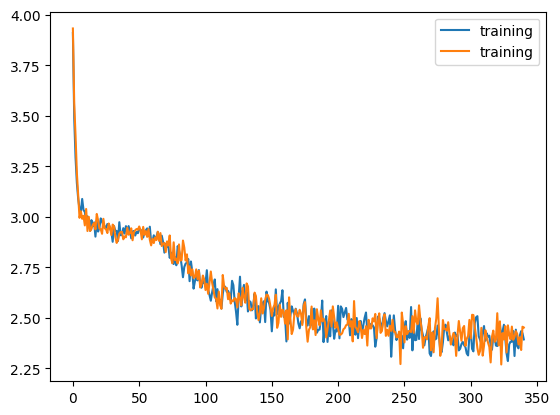

In [513]:
plt.plot(loss_history, label="training")
plt.plot(val_loss_history, label="training")
plt.legend()
plt.show()

In [517]:
logits, loss, acc = model(xb, yb)
print("acc :",acc.numpy()," loss :",loss.numpy())

acc : 0.2513674  loss : 2.2787592


In [518]:
xb, yb = get_batch('val')
logits, loss, acc = model(xb, yb)
print("acc :",acc.numpy()," loss :",loss.numpy())

acc : 0.2514332  loss : 2.263277


In [519]:
model.summary()

Model: "language_model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_64 (Embedding)    multiple                  1984      
                                                                 
 embedding_65 (Embedding)    multiple                  2048      
                                                                 
 block_32 (Block)            multiple                  49792     
                                                                 
 layer_normalization_92 (Lay  multiple                 128       
 erNormalization)                                                
                                                                 
 dense_1403 (Dense)          multiple                  2015      
                                                                 
Total params: 55,969
Trainable params: 55,967
Non-trainable params: 2
_____________________________________________

In [520]:
context = x_val[np.random.randint(len(x_val))]
decoded = decode(context)
print(len(context))
print(decoded)

full_text = ''
for i in range(100):
  context_new = context[-context_size:]
  logits, loss, acc = model(np.array([context_new]))
  prediction = tf.random.categorical(logits[-1,-1:],1)
  full_text += decode(prediction[0])+''
  context = tf.concat([context,prediction[0]],axis=0)

32
e happier for thy son
and now by


In [521]:
print(decoded+' '+full_text)

e happier for thy son
and now by  hou ge ftomes wite nif mbr wathares and witith
e
arglern ulous
tlleran ge the ake the sutat thowent
